In [3]:
import pandas as pd

import os
import spacy 
from spacy import displacy

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [4]:
# Trying to read with more flexible options
try:
    # Attempt with error handling options
    df = pd.read_csv("./car_review_datasets/Scraped_Car_Review_ford.csv", 
                     error_bad_lines=False,  # Skip bad lines
                     warn_bad_lines=True,    # Warn about them
                     encoding='utf-8')       # Explicit encoding
except:
    # If that doesn't work, try a different approach
    df = pd.read_csv("./car_review_datasets/Scraped_Car_Review_ford.csv", 
                     engine='python',        # Python engine is more flexible
                     encoding='utf-8')       # Explicit encoding

In [5]:
df = df.drop('Unnamed: 0', axis=1)
df_fiesta = df[df["Vehicle_Title"].str.contains("Fiesta", na=False)]
df_fiesta["vehicle_age"] = df_fiesta["Vehicle_Title"].str.extract(r'(\d{4})')[0]
df_fiesta["vehicle_age"] = pd.to_numeric(df_fiesta["vehicle_age"])
df_fiesta = df_fiesta[df_fiesta["vehicle_age"] < 2017]
df_fiesta = df_fiesta.reset_index(drop=True)

/tmp/ipykernel_22820/3309848676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fiesta["vehicle_age"] = df_fiesta["Vehicle_Title"].str.extract(r'(\d{4})')[0]
/tmp/ipykernel_22820/3309848676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fiesta["vehicle_age"] = pd.to_numeric(df_fiesta["vehicle_age"])


In [ ]:
df_fiesta_reviews = df_fiesta[["Review", "Rating", "Review_Title", "vehicle_age"]].copy()


In [12]:
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Create a function to get sentiment scores
def get_sentiment(text):
    try:
        # Get sentiment scores
        scores = sid.polarity_scores(text)
        return scores
    except:
        # Return None if there's an error
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

# Apply the function to the 'Review' column
df_fiesta_reviews['sentiment_scores'] = df_fiesta_reviews['Review'].apply(get_sentiment)

# Extract individual sentiment components
df_fiesta_reviews['negative_sentiment'] = df_fiesta_reviews['sentiment_scores'].apply(lambda x: x['neg'])
df_fiesta_reviews['neutral_sentiment'] = df_fiesta_reviews['sentiment_scores'].apply(lambda x: x['neu'])
df_fiesta_reviews['positive_sentiment'] = df_fiesta_reviews['sentiment_scores'].apply(lambda x: x['pos'])
df_fiesta_reviews['compound_sentiment'] = df_fiesta_reviews['sentiment_scores'].apply(lambda x: x['compound'])

# # Add a sentiment category based on compound score
def get_sentiment_category(compound):
    if compound >= 0.2:
        return "Positive"
    elif compound <= -0.2:
        return "Negative"
    else:
        return "Neutral"

df_fiesta_reviews['sentiment_category'] = df_fiesta_reviews['compound_sentiment'].apply(get_sentiment_category)

# Compare average sentiment with average rating
avg_sentiment = df_fiesta_reviews['compound_sentiment'].mean()
avg_rating = df_fiesta_reviews['Rating'].mean()

In [13]:
df_fiesta_reviews

,Review,Rating,Review_Title,vehicle_age,sentiment_scores,negative_sentiment,neutral_sentiment,positive_sentiment,compound_sentiment,sentiment_category
0,We bought a Ford Fiesta 2014 in March. The So...,1.000,Ford Fiesta 2014. Bad idea,2014,"{'neg': 0.094, 'neu': 0.842, 'pos': 0.064, 'co...",0.094,0.842,0.064,-0.6867,Negative
1,"OK, I will be honest, at first I didn't like ...",4.000,A relationship to build over time,2014,"{'neg': 0.054, 'neu': 0.813, 'pos': 0.133, 'co...",0.054,0.813,0.133,0.9858,Positive
2,I rented this car. The transmission problems ...,2.000,Transmission troubles are real,2014,"{'neg': 0.158, 'neu': 0.824, 'pos': 0.018, 'co...",0.158,0.824,0.018,-0.9533,Negative
3,Okay... does this car stutter when you drive ...,5.000,You have to learn how to drive this car,2014,"{'neg': 0.071, 'neu': 0.858, 'pos': 0.07, 'com...",0.071,0.858,0.070,0.1566,Neutral
4,This car is a death trap and an embarrassment...,1.000,RIP. OFF.,2014,"{'neg': 0.26, 'neu': 0.711, 'pos': 0.029, 'com...",0.260,0.711,0.029,-0.9593,Negative
...,...,...,...,...,...,...,...,...,...,...
335,"I love the little car! It's a blast to drive,...",4.250,Buena Fiesta!,2011,"{'neg': 0.018, 'neu': 0.823, 'pos': 0.159, 'co...",0.018,0.823,0.159,0.9577,Positive
336,Overall a very nice car but it could have jus...,3.750,Very nice but needs some obvious changes,2011,"{'neg': 0.103, 'neu': 0.572, 'pos': 0.324, 'co...",0.103,0.572,0.324,0.9625,Positive
337,This is a wonderful car with great build qual...,4.875,Great Car!,2011,"{'neg': 0.011, 'neu': 0.659, 'pos': 0.33, 'com...",0.011,0.659,0.330,0.9945,Positive
338,We have now had our new Fiesta SES hatchback ...,5.000,"Fun, Fit and Finish",2011,"{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou...",0.000,0.660,0.340,0.9883,Positive


In [23]:
# Calculate the average rating

# Get counts of sentiment categories
sentiment_counts = df_fiesta_reviews['sentiment_category'].value_counts()


print(f"Sentiment Analysis:")
print(f"- Average compound sentiment: {avg_sentiment:.3f} on scale (-1 to +1)")
# Calculate percentages of each sentiment category
for category, count in sentiment_counts.items():
    percentage = count / len(df_fiesta_reviews) * 100
    print(f"- {category}: {count} reviews ({percentage:.1f}%)")

# Calculate percentage of positive vs negative ratings
rating_positive = len(df_fiesta_reviews[df_fiesta_reviews['Rating'] >= 3.5])
rating_neutral = len(df_fiesta_reviews[(df_fiesta_reviews['Rating'] > 2.5) & (df_fiesta_reviews['Rating'] < 3.5)])
rating_negative = len(df_fiesta_reviews[df_fiesta_reviews['Rating'] <= 2.5])



print("\nRating Distribution:")
print(f"Average Rating: {avg_rating:.2f} out of 5.00")

print(f"- Positive (≥3.5): {rating_positive} reviews ({rating_positive/len(df_fiesta_reviews)*100:.1f}%)")
print(f"- Neutral (>2.5 & <3.5): {rating_neutral} reviews ({rating_neutral/len(df_fiesta_reviews)*100:.1f}%)")
print(f"- Negative (≤2.5): {rating_negative} reviews ({rating_negative/len(df_fiesta_reviews)*100:.1f}%)")


# Create a simple correlation
corr = df_fiesta_reviews[['Rating', 'compound_sentiment']].corr().iloc[0, 1]
print(f"\nCorrelation between ratings and sentiment scores: {corr:.3f}")

Sentiment Analysis:
- Average compound sentiment: 0.299 on scale (-1 to +1)
- Positive: 215 reviews (63.2%)
- Negative: 109 reviews (32.1%)
- Neutral: 16 reviews (4.7%)

Rating Distribution:
Average Rating: 3.39 out of 5.00
- Positive (≥3.5): 190 reviews (55.9%)
- Neutral (>2.5 & <3.5): 42 reviews (12.4%)
- Negative (≤2.5): 107 reviews (31.5%)

Correlation between ratings and sentiment scores: 0.626


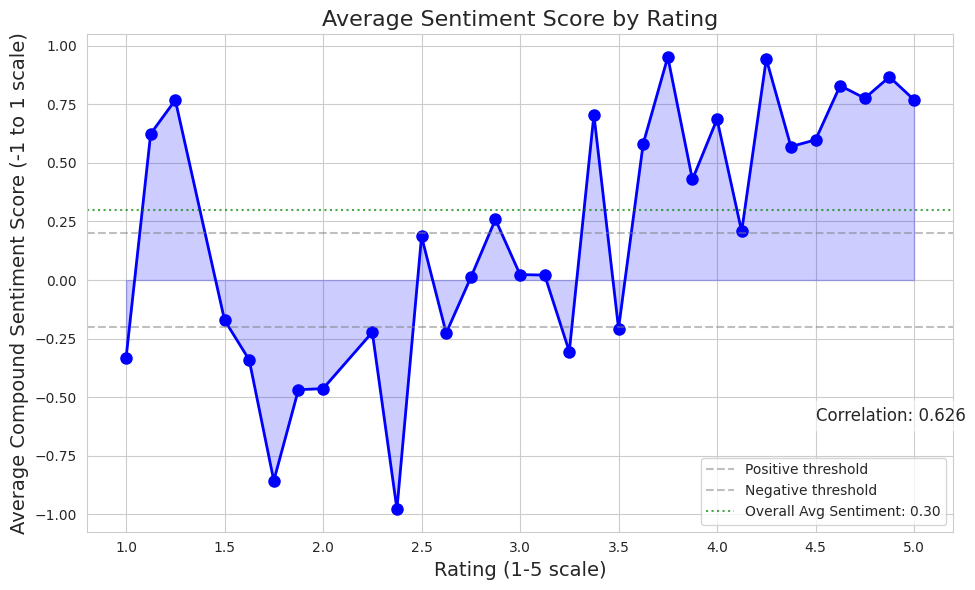

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Group by rating and calculate the mean sentiment for each group
sentiment_by_rating = df_fiesta_reviews.groupby('Rating')['compound_sentiment'].mean().reset_index()

# Set the style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create line plot of average sentiment by rating
plt.plot(sentiment_by_rating['Rating'], sentiment_by_rating['compound_sentiment'], 
         marker='o', markersize=8, linewidth=2, color='blue')

# Fill the area under the line with light blue
plt.fill_between(sentiment_by_rating['Rating'], sentiment_by_rating['compound_sentiment'], 
                 alpha=0.2, color='blue')

# Add horizontal lines to mark sentiment category boundaries
plt.axhline(y=0.2, color='gray', linestyle='--', alpha=0.5, label='Positive threshold')
plt.axhline(y=-0.2, color='gray', linestyle='--', alpha=0.5, label='Negative threshold')

# Enhance the plot
plt.title('Average Sentiment Score by Rating', fontsize=16)
plt.xlabel('Rating (1-5 scale)', fontsize=14)
plt.ylabel('Average Compound Sentiment Score (-1 to 1 scale)', fontsize=14)

# Add correlation information as text
plt.text(4.5, -0.6, f'Correlation: {corr:.3f}', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5))

# Add overall average sentiment line
plt.axhline(y=avg_sentiment, color='green', linestyle=':', alpha=0.7, 
           label=f'Overall Avg Sentiment: {avg_sentiment:.2f}')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# Define thresholds
positive_sentiment_threshold = 0.5  # High positive sentiment
low_rating_threshold = 1.5  # Below average rating

# Find examples where sentiment is high but rating is low
contradictory_reviews = df_fiesta_reviews[
    (df_fiesta_reviews['compound_sentiment'] > positive_sentiment_threshold) & 
    (df_fiesta_reviews['Rating'] < low_rating_threshold)
]

# Sort by the difference between sentiment and normalized rating
contradictory_reviews['sentiment_rating_gap'] = contradictory_reviews['compound_sentiment'] - (contradictory_reviews['Rating'] / 5.0)
contradictory_reviews = contradictory_reviews.sort_values('sentiment_rating_gap', ascending=False)

# Display the most interesting examples
if len(contradictory_reviews) > 0:
    print(f"Found {len(contradictory_reviews)} reviews with high sentiment but low rating\n")
    
    # Show the top examples
    for idx, row in contradictory_reviews.head(5).iterrows():
        print(f"Rating: {row['Rating']}/5.0 | Sentiment Score: {row['compound_sentiment']:.3f}")
        print(f"Review Title: {row['Review_Title']}")
        print(f"Review: {row['Review'][:200]}...")  # Show first 200 chars of review
        print("-" * 80)
else:
    print("No examples found where sentiment is high but rating is low.")

Found 13 reviews with high sentiment but low rating

Rating: 1.0/5.0 | Sentiment Score: 0.990
Review Title: Don't buy this car.
Review:  Acceleration - dismal at best, I wouldn't want to be in front of a semi-truck when the light turns green.Bluetooth - in theory it's fine.  But to turn it on, you have to use the voice activation and ...
--------------------------------------------------------------------------------
Rating: 1.0/5.0 | Sentiment Score: 0.985
Review Title: LEMON!!
Review:  I purchased a used 2012 model from my local Ford dealer as a graduation gift for my daughter in 2013.  This car has been nothing but trouble almost from the start!  We have had to take the car in for...
--------------------------------------------------------------------------------
Rating: 1.0/5.0 | Sentiment Score: 0.970
Review Title: Not a good choice !
Review:  I bought my 2012 Ford Fiesta brand new and loved it . It was cute and drove great! Right when I hit about 30,000 miles , everything went do

/tmp/ipykernel_22820/2667901040.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contradictory_reviews['sentiment_rating_gap'] = contradictory_reviews['compound_sentiment'] - (contradictory_reviews['Rating'] / 5.0)
